# SVM Classifier

SVCs aim to find a hyperplane that effectively separates the classes in their training data by maximizing the margin between the outermost data points of each class.

If the data is not linearly separable in the original feature space, a non-linear kernel parameter can be set. Depending on the kernel, the process involves adding new features or transforming existing features to enrich and potentially add meaning to the data. When a kernel other than "linear" is set, the SVC applies the kernel trick, which computes the similarity between pairs of data points using the kernel function without explicitly transforming the entire dataset.

[sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


sns.set_palette("Blues")

In [2]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)


    cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=['Actual Negative:0','Actual Positive:1'])

    sns.heatmap(cm_matrix, annot=True, fmt='d',cmap="Blues")
    plt.show()

    cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')


    cm_normalized_matrix = pd.DataFrame(data=cm_normalized, columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=['Actual Negative:0','Actual Positive:1'])

    sns.heatmap(cm_normalized_matrix, annot=True, fmt='.3f',cmap="Blues")
    plt.show()

In [3]:
def get_metrics(y_test,y_pred):
    print("Accuracy: ", round(accuracy_score(y_test,y_pred),4))
    print("F1 score: ", round(f1_score(y_test,y_pred),4))
    print("Recall: ", round(recall_score(y_test,y_pred),4))
    print("Precision: ", round(precision_score(y_test,y_pred),4))

## Load data

In [4]:
ssa_n10 = pd.read_csv("C:\\Users\\julia\\Documents\\UNICAMP\\TCC\\Final_datasets\\ssa_l20_n10.csv")

### Sanity checks

In [20]:
ssa_n10['label'].value_counts()

label
1    8316
0    1920
Name: count, dtype: int64

In [21]:
ssa_n10['bearing'].value_counts()

bearing
K001    320
K002    320
KI18    320
KI17    320
KI16    320
KI14    320
KI04    320
KB27    320
KB24    320
KB23    320
KA30    320
KA22    320
KA16    320
KA15    320
KA04    320
KI08    320
KI07    320
KI05    320
KI03    320
KI01    320
KA09    320
KA07    320
KA06    320
KA05    320
KA03    320
KA01    320
K006    320
K005    320
K004    320
K003    320
KI21    320
KA08    316
Name: count, dtype: int64

In [22]:
ssa_n10.columns

Index(['min_phase_current_1_ssa_0', 'max_phase_current_1_ssa_0',
       'median_phase_current_1_ssa_0', 'mean_phase_current_1_ssa_0',
       'rms_phase_current_1_ssa_0', 'std_phase_current_1_ssa_0',
       'range_phase_current_1_ssa_0', 'min_phase_current_2_ssa_0',
       'max_phase_current_2_ssa_0', 'median_phase_current_2_ssa_0',
       ...
       'rms_vibration_ssa_9', 'std_vibration_ssa_9', 'range_vibration_ssa_9',
       'rotation_speed', 'load_torque', 'radial_force', 'bearing', 'label',
       'label_detailed', 'category'],
      dtype='object', length=217)

## Split train and test

In [5]:
# keep samples of the same configuration in the train or test df
unique_cat = ssa_n10["category"].unique()
train_ids, test_ids = train_test_split(unique_cat, test_size=0.33, random_state=42)

train_df = ssa_n10[ssa_n10["category"].isin(train_ids)]
test_df = ssa_n10[ssa_n10["category"].isin(test_ids)]

In [24]:
len(train_df)

6800

In [25]:
len(test_df)

3436

In [26]:
print(f"Unique bearings train: {len(train_df['bearing'].unique())} \nUnique bearings test: {len(test_df['bearing'].unique())}" )

Unique bearings train: 32 
Unique bearings test: 26


In [27]:
print(f"Unique bearings train: {len(train_df['label_detailed'].unique())} \nUnique bearings test: {len(test_df['label_detailed'].unique())}" )

Unique bearings train: 3 
Unique bearings test: 3


In [28]:
print(train_df['label_detailed'].value_counts())

label_detailed
accelerated_lifetime    3120
articially_damaged      2480
normal                  1200
Name: count, dtype: int64


In [29]:
print(test_df['label_detailed'].value_counts())

label_detailed
accelerated_lifetime    1360
articially_damaged      1356
normal                   720
Name: count, dtype: int64


## Using phase current data

In [6]:
# Split train and test
X_train_current = train_df.filter(like='current')
X_test_current = test_df.filter(like='current')

y_train_current = train_df['label']
y_test_current = test_df['label']


# scaler
scaler = StandardScaler()

X_train_current = scaler.fit_transform(X_train_current)

X_test_current = scaler.transform(X_test_current)

## Grid Search

[grid search documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

C: Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
- to reduce effect of outliers, we should increase C value

kernel: Specifies the kernel type to be used in the algorithm
- see [documentation](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#sphx-glr-auto-examples-svm-plot-svm-kernels-py)

gamma: kernel coefficient 
- defines how far the influence of a single training example reaches. In other words, it affects the 'smoothness' or 'wiggliness' of the decision boundary.

In [31]:
parameters = [ {'C':[0.1, 1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[0.1, 1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[0.1, 1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]

In [32]:
svc= svm.SVC()
grid_search_current = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5, #cross validation
                           verbose=0)


grid_search_current.fit(X_train_current, y_train_current)

# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search_current.best_score_))

# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search_current.best_params_))

# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search_current.best_estimator_))

GridSearch CV best score : 0.8887


Parameters that give the best results : 

 {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}


Estimator that was chosen by the search : 

 SVC(C=0.1, degree=2, gamma=0.01, kernel='poly')


### Results of the best estimator

In [33]:
y_pred_current = grid_search_current.best_estimator_.predict(X_test_current)
print(classification_report(y_test_current, y_pred_current))

              precision    recall  f1-score   support

           0       0.80      0.59      0.68       720
           1       0.90      0.96      0.93      2716

    accuracy                           0.88      3436
   macro avg       0.85      0.77      0.80      3436
weighted avg       0.88      0.88      0.88      3436



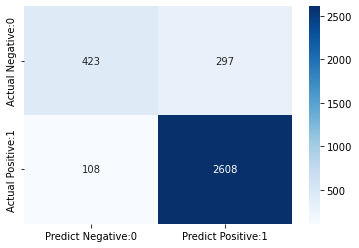

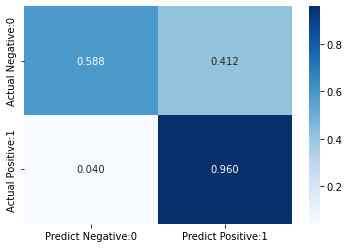

In [8]:
plot_confusion_matrix(y_test_current,y_pred_current)

In [35]:
get_metrics(y_test_current,y_pred_current)

Accuracy:  0.8821
F1 score:  0.9279
Recall:  0.9602
Precision:  0.8978


## Using Vibration data

In [9]:
# Split train and test
X_train_vib = train_df.filter(like='vib')
X_test_vib = test_df.filter(like='vib')
y_train_vib = train_df['label']
y_test_vib = test_df['label']

# scaler
scaler = StandardScaler()

X_train_vib = scaler.fit_transform(X_train_vib)

X_test_vib = scaler.transform(X_test_vib)

In [37]:
svc= svm.SVC()
grid_search_vib = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5, #cross validation
                           verbose=0)


grid_search_vib.fit(X_train_vib, y_train_vib)

# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search_vib.best_score_))

# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search_vib.best_params_))

# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search_vib.best_estimator_))

GridSearch CV best score : 0.9368


Parameters that give the best results : 

 {'C': 0.1, 'degree': 3, 'gamma': 0.03, 'kernel': 'poly'}


Estimator that was chosen by the search : 

 SVC(C=0.1, gamma=0.03, kernel='poly')


### Results of the best estimator

In [38]:
y_pred_vib = grid_search_vib.best_estimator_.predict(X_test_vib)
print(classification_report(y_test_vib, y_pred_vib))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       720
           1       0.97      0.99      0.98      2716

    accuracy                           0.96      3436
   macro avg       0.96      0.93      0.94      3436
weighted avg       0.96      0.96      0.96      3436



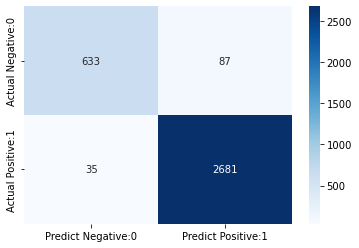

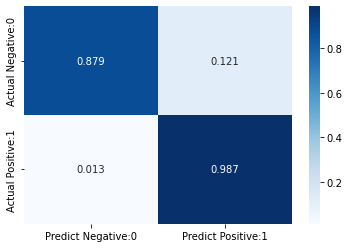

In [11]:
plot_confusion_matrix(y_test_vib, y_pred_vib)

In [40]:
get_metrics(y_test_vib,y_pred_vib)

Accuracy:  0.9645
F1 score:  0.9778
Recall:  0.9871
Precision:  0.9686


## Using all data

In [12]:
X_train_all = train_df.drop(columns= {'rotation_speed', 'load_torque',
       'radial_force', 'bearing', 'label', 'label_detailed','category'})
X_test_all = test_df.drop(columns= {'rotation_speed', 'load_torque',
       'radial_force', 'bearing', 'label', 'label_detailed','category'})
y_train_all = train_df['label']
y_test_all = test_df['label']

scaler = StandardScaler()

X_train_all = scaler.fit_transform(X_train_all)

X_test_all = scaler.transform(X_test_all)

In [42]:
svc= svm.SVC()
grid_search_all = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5, #cross validation
                           verbose=0)


grid_search_all.fit(X_train_all, y_train_all)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100, 1000],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 100, 1000], 'degree': [2, 3, 4],
                          'gamma': [0.01, 0.02, 0.03, 0.04, 0.05],
                          'kernel': ['poly']}],
             scoring='accuracy')

In [43]:
# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search_all.best_score_))


# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search_all.best_params_))


# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search_all.best_estimator_))

GridSearch CV best score : 0.9174


Parameters that give the best results : 

 {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}


Estimator that was chosen by the search : 

 SVC(C=0.1, degree=2, gamma=0.01, kernel='poly')


### Resuls of best estimator

In [44]:
y_pred_all = grid_search_all.best_estimator_.predict(X_test_all)
print(classification_report(y_test_all, y_pred_all))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       720
           1       0.97      1.00      0.98      2716

    accuracy                           0.97      3436
   macro avg       0.98      0.93      0.96      3436
weighted avg       0.97      0.97      0.97      3436



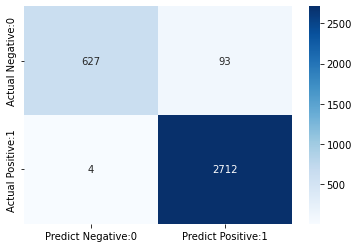

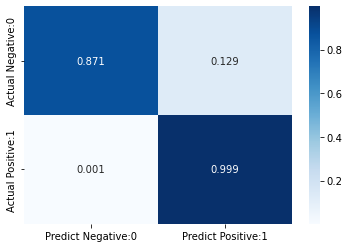

In [14]:
plot_confusion_matrix(y_test_all, y_pred_all)

In [15]:
get_metrics(y_test_all,y_pred_all)

Accuracy:  0.9718
F1 score:  0.9824
Recall:  0.9985
Precision:  0.9668
